In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')

In [4]:
print(df.columns)

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [5]:
group_cols = {
    'Frequency': ['Order Id'],  
    'Severity': ['Sales per customer', 'Order Item Quantity', 'Order Item Product Price'],
    'LeadTime': ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']
}

In [6]:
df_grouped = df.groupby('Customer Id').agg({
    'Order Id': 'count',
    'Sales per customer': 'mean',
    'Order Item Quantity': 'mean',
    'Order Item Product Price': 'mean',
    'Days for shipping (real)': 'mean',
    'Days for shipment (scheduled)': 'mean',
    'Order Item Total': 'mean'
}).rename(columns={'Order Id': 'Order Count'})

In [7]:
scaler = MinMaxScaler()
norm_features = ['Order Count', 'Sales per customer', 'Order Item Quantity', 'Order Item Product Price',
                 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']

In [8]:
df_norm = df_grouped.copy()
df_norm[norm_features] = scaler.fit_transform(df_norm[norm_features])

In [9]:
df_norm['F_norm'] = df_norm['Order Count']
df_norm['S_norm'] = df_norm[['Sales per customer', 'Order Item Quantity', 'Order Item Product Price']].mean(axis=1)
df_norm['L_norm'] = df_norm[['Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']].mean(axis=1)

In [10]:
X = df_norm[['F_norm', 'S_norm', 'L_norm']]
pca = PCA(n_components=3)
pca.fit(X)
pca_weights = pca.explained_variance_ratio_
pca_weights /= pca_weights.sum()

In [11]:
equal_weights = np.array([1/3, 1/3, 1/3])

In [12]:
heuristic_weights = np.array([0.4, 0.35, 0.25])

In [13]:
df_norm['SCRI_heuristic'] = X.dot(heuristic_weights)
df_norm['SCRI_pca'] = X.dot(pca_weights)
df_norm['SCRI_equal'] = X.dot(equal_weights)

In [14]:
df_norm['Rank_heuristic'] = df_norm['SCRI_heuristic'].rank(ascending=True)
df_norm['Rank_pca'] = df_norm['SCRI_pca'].rank(ascending=True)
df_norm['Rank_equal'] = df_norm['SCRI_equal'].rank(ascending=True)

In [15]:
output_cols = ['F_norm', 'S_norm', 'L_norm',
               'SCRI_heuristic', 'SCRI_pca', 'SCRI_equal',
               'Rank_heuristic', 'Rank_pca', 'Rank_equal']

In [16]:
df_norm[output_cols].to_csv('scri_results.csv')

In [17]:
print("SCRI computation complete!")
print("Output saved to scri_results.csv")
print("\nWeights used:")
print(f"Heuristic Weights: F=0.4, S=0.35, L=0.25")
print("PCA-derived Weights:", np.round(pca_weights, 3))
print("Equal-risk Weights:", np.round(equal_weights, 3))

SCRI computation complete!
Output saved to scri_results.csv

Weights used:
Heuristic Weights: F=0.4, S=0.35, L=0.25
PCA-derived Weights: [0.527 0.352 0.121]
Equal-risk Weights: [0.333 0.333 0.333]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
df = pd.read_csv("scri_results.csv")

In [3]:
assert 'SCRI_heuristic' in df.columns, "Missing SCRI_heuristic column"

In [11]:
threshold = df['SCRI_heuristic'].quantile(0.50)
df['label'] = (df['SCRI_heuristic'] >= threshold).astype(int)

In [ ]:
# df.to_csv("scri_results_labeled.csv", index=False)

In [12]:
y_true = df['label']
y_scores = df['SCRI_heuristic']

In [13]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

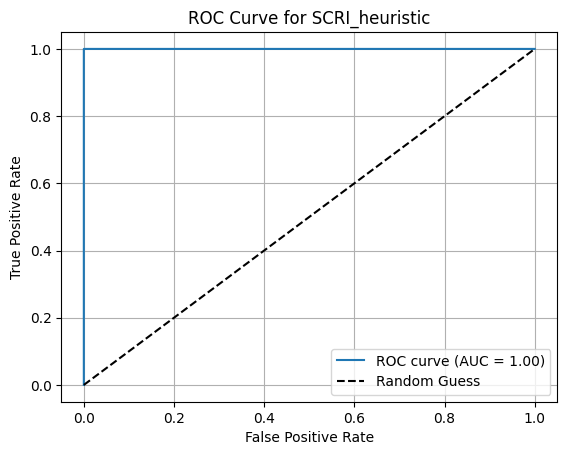

In [14]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SCRI_heuristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [15]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

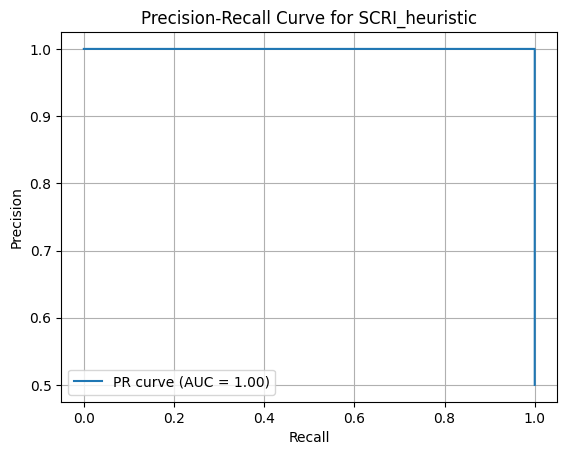

In [16]:
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SCRI_heuristic')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

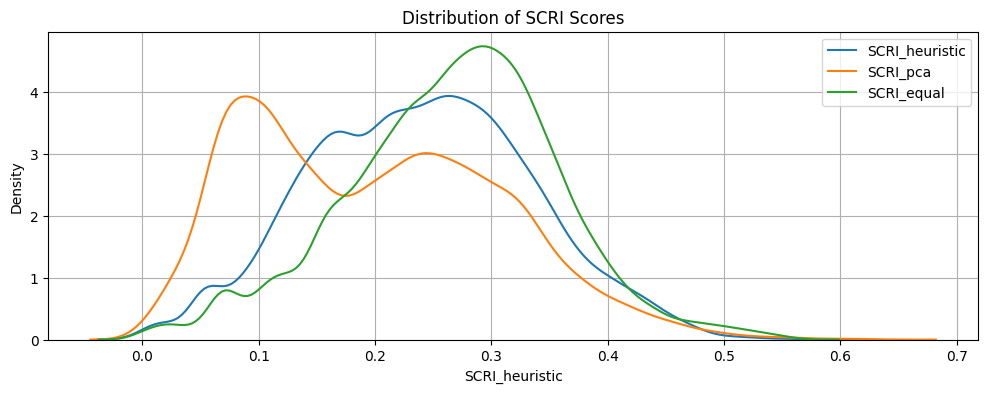

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 4))
for col in ['SCRI_heuristic', 'SCRI_pca', 'SCRI_equal']:
    sns.kdeplot(df[col], label=col)
plt.title("Distribution of SCRI Scores")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df = pd.read_csv("scri_results.csv")

In [22]:
f_thresh = df['F_norm'].quantile(0.50)
s_thresh = df['S_norm'].quantile(0.50)

In [23]:
df['label'] = ((df['F_norm'] >= f_thresh) & (df['S_norm'] >= s_thresh)).astype(int)

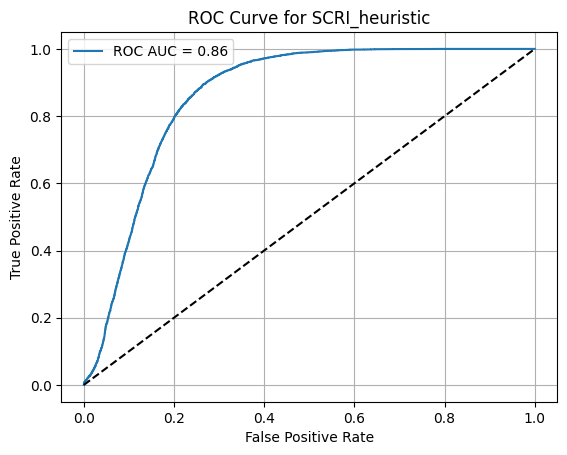

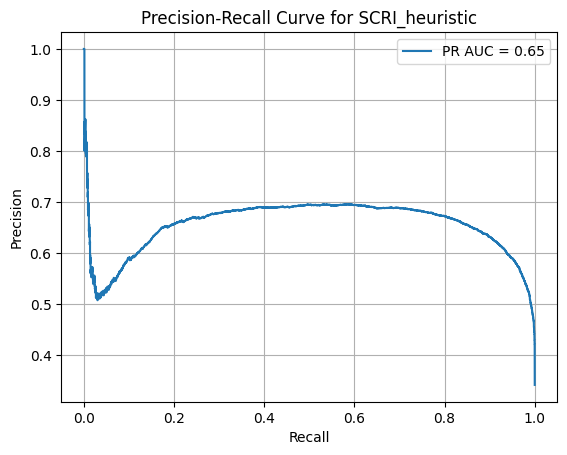

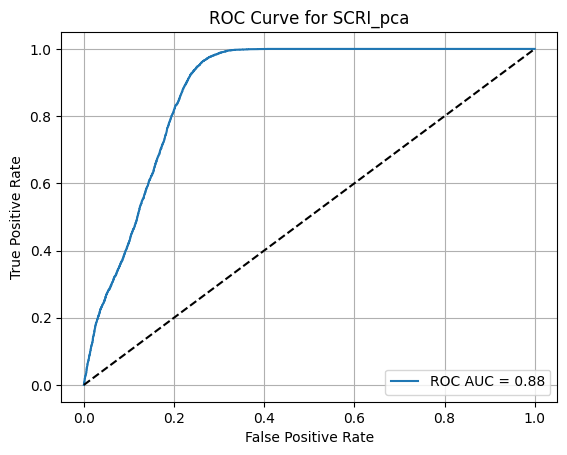

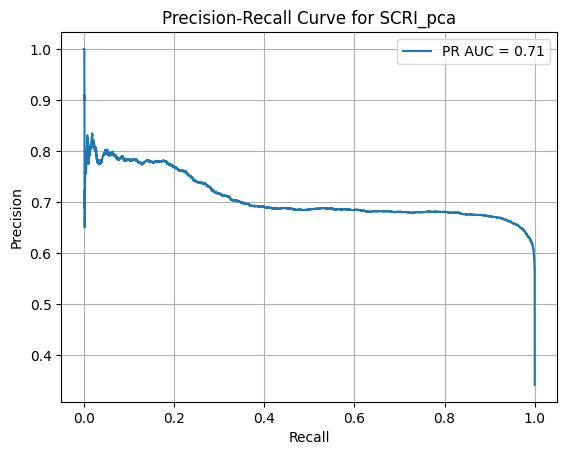

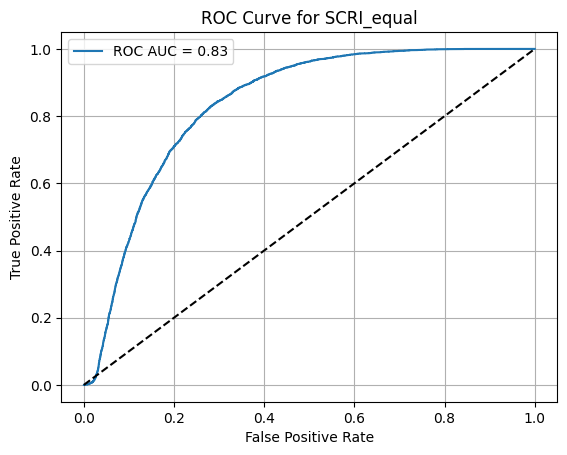

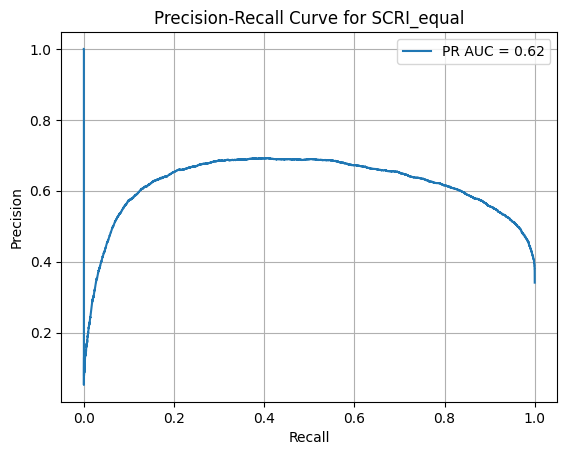

In [24]:
for col in ['SCRI_heuristic', 'SCRI_pca', 'SCRI_equal']:
    y_scores = df[col]
    y_true = df['label']
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    
    # Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve for {col}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot PR
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.title(f'Precision-Recall Curve for {col}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()